In [4]:
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import git
repo_path = git.Repo('.', search_parent_directories=True).working_tree_dir

In [2]:
def load_data(path, closest_d_tol=1e-6):

    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    exact_min = np.min(data['eigenvalues'])
    final_k = data['final_k']

    all_run_data = data["all_run_data"]
    keys = all_run_data[0].keys()

    cols = {k: [d.get(k) for d in all_run_data] for k in keys}

    reduction_percentages = cols["reduction"]
    reduced_eigenvalues = cols["H_reduced_e"]
    diff_to_mins = cols["diff"]

    first_idx_tol = next((i for i, d in enumerate(diff_to_mins) if abs(d) <= closest_d_tol), None) #index of first step that is within specified tolerance

    num_samples = cols["num_samples"]

    row = {
        "N": data["N"],
        "cutoff": data["cutoff"],
        "exact_min": exact_min,
        "final_k": final_k,
        "reduced_eigenvalues": reduced_eigenvalues,
        "reduction_percentages": reduction_percentages,
        "num_samples": num_samples,
        "diff_to_mins": diff_to_mins,
        "first_idx_tol": first_idx_tol
    }

    return row

In [6]:
def plot_individual(data, show=True, save=False):

    potential = data['potential']
    cutoff = data['cutoff']
    idx_tol =data['first_idx_tol']

    y_left = data['reduction_percentages']
    y_right = data["diff_to_mins"]
    x = range(data['final_k'])

    fig, ax1 = plt.subplots(figsize=(9, 5))


    # Left axis
    l1 = ax1.plot(x, y_left, marker="o", label="H Reduction %")
    ax1.set_xlabel('D')
    ax1.set_ylabel("H Reduction %")
    ax1.grid(True, alpha=0.3)

    # Right axis
    ax2 = ax1.twinx()
    l2 = ax2.plot(x, y_right, marker="s", color='r', label="Diff to Min")
    ax2.set_ylabel("Diff to Min")

    # if idx_tol: 
    #     vl = ax1.axvline(x=idx_tol, linestyle="--", color="k", linewidth=1.5, alpha=0.8, zorder=0, label=f"threshold = {data['conv_tol']}")
    #     lines = l1 + l2 + [vl]
    # else:
    lines = l1 + l2
        
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc="best")

    plt.title(f"{data['label']} - {data['bc']} - {potential} - N{data['N']} - $\\Lambda${cutoff}")
    plt.tight_layout()

    if show and not save:
        plt.show()
    
    if save:
        save_path = os.path.dirname(data['path'])
        plt.savefig(os.path.join(save_path, f"{potential}_{cutoff}.png"))
        plt.close()


In [7]:
root = os.path.join(repo_path, r"SUSY\Wess-Zumino\Qiskit\SBQKD\AnsatzComp")
labels = ['EvolOnly','BasisOnly','Basis+RYs','Basis+XXYYs','Full']
#labels = ['Full']
sites = [2,3,4,5,6]
cutoffs = [2,4,8,16]
bc = "dirichlet"
potential = "linear"

all_data = []
conv_tol = 1e-6
for label in labels:
    for site in sites:
        for cutoff in cutoffs:

            path = os.path.join(root, label, bc, potential, f"N{site}", f"{potential}_{cutoff}.json")
            try:
                data = load_data(path, conv_tol)
            except:
                continue
            
            data['path'] = path
            data['label'] = label
            data['potential'] = potential
            data['bc'] = bc
            data['conv_tol'] = conv_tol

            plot_individual(data, show=False, save=True)

            all_data.append(data)

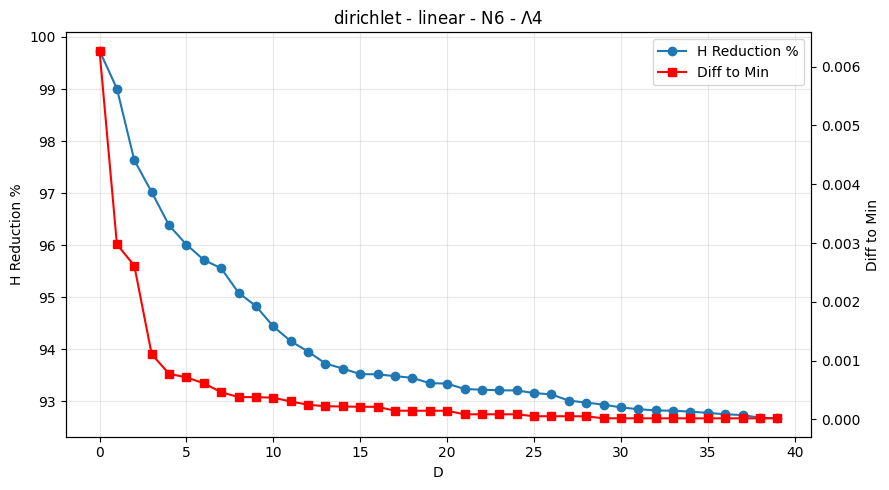

In [63]:
data = pd.DataFrame(all_data).iloc[-1]
plot_individual(data, show=True)

In [8]:
def plot_multi(
    data,
    ax1=None,
    ax2=None,
    show=True,
    show_left=True,
    show_right=True,
    add_vline=True,
    add_legend=True,
):
    created = False
    if ax1 is None:
        fig, ax1 = plt.subplots(figsize=(9, 5))
        created = True

    # Create right axis only if needed
    if show_right and ax2 is None:
        ax2 = ax1.twinx()

    x = range(data["final_k"])
    lines = []

    # Left plot
    if show_left:
        y_left = data["reduction_percentages"]
        left_line = ax1.plot(
            x, y_left, marker="o", markersize=4, linewidth=1.5, label=data["label"]
        )[0]
        lines.append(left_line)
        ax1.set_ylabel("H Reduction %")
        ax1.grid(True, alpha=0.3)
    else:
        ax1.yaxis.set_visible(False)
        ax1.spines["left"].set_visible(False)

    # Right plot
    if show_right:
        y_right = data["diff_to_mins"]
        lines += ax2.plot(x, y_right, marker="s", linewidth=1.5, label="Diff to Min")
        ax2.set_ylabel("Diff to Min")
    else:
        # if ax2 exists from an overlay call, hide it
        if ax2 is not None:
            ax2.yaxis.set_visible(False)
            ax2.spines["right"].set_visible(False)

    ax1.set_xlabel("D")

    # vline (only if we have an x-axis context; ax1 always exists)
    idx_tol = data.get("first_idx_tol", None)
    if add_vline and idx_tol is not None:
        vcolor = left_line.get_color() if left_line is not None else "k"
        vl = ax1.axvline(idx_tol, linestyle="--", linewidth=1.0, color=vcolor, alpha=0.8)#, label=f"tol={data.get('conv_tol','')}")
        #lines += [vl]

    if add_legend and lines: 
        ax1.legend(lines, [ln.get_label() for ln in lines], loc="best", fontsize=9)

    if created:
        plt.tight_layout()
        if show:
            plt.show()

    return ax1, ax2


In [ ]:
bc = "dirichlet"
potential = "linear"

for N in sites:
    for cutoff in cutoffs:
        data = [d for d in all_data if (d.get("N") == N) and (d.get("cutoff") == cutoff)]

        if len(data) > 0:
            fig, ax1 = plt.subplots(figsize=(9, 5))
            ax2 = ax1.twinx()

            ax1.set_xlabel("D")
            ax1.set_ylabel("H Reduction %")
            ax1.grid(True, alpha=0.3)
            ax2.set_ylabel("Diff to Min")

            add_vline=True
            for d in data:   
                plot_multi(d, ax1=ax1, ax2=ax2, show=False, show_left=True, show_right=False,add_legend=False, add_vline=add_vline)
                #if d['first_idx_tol']: add_vline=False

            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best", fontsize=9)

            plt.title(f"{bc} - {potential} - N{N} - $\\Lambda${cutoff}")
            plt.tight_layout()
            #plt.show()

            save_path = os.path.join(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\Wess-Zumino\Qiskit\SBQKD\AnsatzComp\Plots", f"{bc}-{potential}-N{N}-L{cutoff}")
            plt.savefig(save_path)

        #break
    break

In [11]:
def plot_multi(
    data,
    ax=None,
    show=True,
    add_legend=True,
    mark_convergence=True,
    conv_registry=None,
    conv_jitter_frac=0.006,
    conv_marker="x",
    colour='b'
):
    if conv_registry is None:
        conv_registry = {}

    created = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 5))
        created = True

    x = np.arange(int(data["final_k"]))
    y=(np.asarray([100.00]*len(data["reduction_percentages"]))-np.asarray((data["reduction_percentages"])))
    #y = np.asarray(data["diff_to_mins"], dtype=float)

    # main line
    (line,) = ax.plot(
        x, y,
        marker="o", markersize=4, linewidth=1.5, color=colour,
        label=data.get("label", "")
    )

    ax.grid(True, alpha=0.3)

    # convergence handling
    idx_tol = data.get("first_idx_tol", None)
    if idx_tol is not None:
        idx_tol = int(idx_tol)
        idx_tol = max(0, min(idx_tol, len(y) - 1))

        if mark_convergence:
            x_span = float(np.max(x) - np.min(x)) if len(x) > 1 else 1.0
            jitter = conv_jitter_frac * x_span

            used = conv_registry.get(idx_tol, 0)
            conv_registry[idx_tol] = used + 1

            if used == 0:
                dx = 0.0
            else:
                k = (used + 1) // 2
                dx = (k * jitter) * (1 if used % 2 == 1 else -1)

            ax.plot(
                [idx_tol + dx],
                [y[idx_tol]],
                marker=conv_marker,
                linestyle="None",
                markersize=6,
                markeredgecolor=line.get_color(),
                markeredgewidth=1.0,
                zorder=0,
            )

    if add_legend:
        ax.legend(loc="best", fontsize=9)

    if created:
        plt.tight_layout()
        if show:
            plt.show()

    return ax, conv_registry


In [13]:
bc = "dirichlet"
potential = "linear"
colours = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
out_dir = os.path.join(repo_path, r"SUSY\Wess-Zumino\Qiskit\SBQKD\AnsatzComp\Plots")
os.makedirs(out_dir, exist_ok=True)

for N in sites:
    for cutoff in cutoffs:
        data = [d for d in all_data if (d.get("N") == N) and (d.get("cutoff") == cutoff)]
        if not data:
            continue

        fig, ax = plt.subplots(figsize=(9, 5))
        registry = {}

        # Set once per figure
        ax.set_xlabel("D")
        ax.set_ylabel("H Reduction %")
        #ax.set_ylabel("|$\\Delta_{min}$|")
        ax.grid(True, alpha=0.3)

        for i, d in enumerate(data):
            
            colour = colours[i % len(colours)]
            ax, registry = plot_multi(
                d,
                ax=ax,
                show=False,
                add_legend=False,
                mark_convergence=True,
                conv_registry=registry,
                colour=colour
            )

        ax.legend(loc="best", fontsize=9)
        ax.set_title(f"{bc} - {potential} - N{N} - $\\Lambda${cutoff}")
        #plt.yscale('log')
        plt.tight_layout()


        save_path = os.path.join(out_dir, f"{bc}-{potential}-N{N}-L{cutoff}.png")
        plt.savefig(save_path, dpi=200)
        plt.close(fig)
        #plt.show()

